In [1]:
## Data Preparation
import pandas as pd
import duckdb as ddb
import numpy as np

# Plotting
import matplotlib.pyplot as plt

## Sklearn
from sklearn.model_selection import train_test_split

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence



In [2]:
## Establish connection
con = ddb.connect("../data/ncm-research-data.duckdb")

## LSTM based Deep Learning Approaches

For Deep Learning approaches, we are curious to explore the potential of using Recurrent Neural Network (RNN), especially the Long-Short Term Memory (LSTM) based models to process time series of user's daily statistics intended to capture more hidden details that are flattened when processed into a single input for traditional machine learning appoaches. For this reason, the data structure is re-designed:

Because the data is adjusted to day level, *Per-Day* is removed. Moreover, Features in *Aggregated* and *Preference* are adjusted and enriched with a few new metrics that can be extracted from daily data 

### 1.1 Time Series Preparation

Following features are not applicable or have better alternatives, thus removed or presented in different ways:

- *active_days*: Not applicable for day-level data

- *favorite_hour*: Replaced with first and last hour of impressions.

- *favorite_format*: Replaced with the percentage of video mlog among **clicked** impressions.

- *favorite_creator_type*: Decided to be merged into static demographical features.

- *avg_impression_position*: Changed to max impression postion.

These new features are added to the model to magnify the advantage of using time series as input.

- *first_act_hour* / *last_act_hour*: Records the first/last hour that a user had impressions.

- *video_format_rate*: The percentage of video mlogs among **clicked** impressions.

- *max_impression_position*: Represents the max depth that a user scrolled down.

- *streak*: Numbers of consecutive active days.

The script below peform preliminary aggregations through SQL and shows result, which is groupped by *userId* and *day_num* (N th day of the observation window).


In [3]:
con.sql("""
WITH aggregated AS (
	SELECT
		userId,
		oi.first_act_dt,
		oi.dt,
		COUNT(oi.mlogId) AS total_impressions,
		COUNT(IF(isClick = 1, oi.mlogId, NULL)) AS total_clicks,
		COUNT(IF(isLike = 1, oi.mlogId, NULL)) AS total_likes,
		COUNT(IF(isShare = 1, oi.mlogId, NULL)) AS total_shares,
		COUNT(IF(isComment = 1, oi.mlogId, NULL)) AS total_comments,
		COUNT(IF(isIntoPersonalHomepage = 1, oi.mlogId, NULL)) AS total_into_personal_pages,
		COUNT(IF(isViewComment = 1, oi.mlogId, NULL)) AS total_view_comments,
		COALESCE(
			SUM(mlogViewTime) / 60,
			0
		) AS total_mlog_watchtime,
		COUNT(IF(isClick = 1, oi.mlogId, NULL)) / COUNT(oi.mlogId) AS impression_ctr,
		COUNT(IF(isLike = 1 OR isShare = 1 OR isComment = 1 OR isIntoPersonalHomepage = 1 OR isViewComment = 1, oi.mlogId, NULL)) / COUNT(oi.mlogId) AS interaction_rate,
		COALESCE(
			COUNT(IF(isLike = 1, oi.mlogId, NULL)) * 1.0 / NULLIF(
				COUNT(IF(isClick = 1, oi.mlogId, NULL)),
				0
			),
			0
		)AS like_rate,
		COALESCE(
			COUNT(IF(isShare = 1, oi.mlogId, NULL)) * 1.0 / NULLIF(
				COUNT(IF(isClick = 1, oi.mlogId, NULL)),
				0
			),
			0
		)AS share_rate,
		COALESCE(
			COUNT(IF(isComment = 1, oi.mlogId, NULL)) * 1.0 / NULLIF(
				COUNT(IF(isClick = 1, oi.mlogId, NULL)),
				0
			),
			0
		)AS comment_rate,
		MAX(impressPosition) AS max_impress_position, 
		CASE
			WHEN COUNT(IF(isClick = 1, oi.mlogId, NULL)) > 0 THEN COUNT(IF(md.type = 2, oi.mlogId, NULL)) / COUNT(IF(isClick = 1, oi.mlogId, NULL)) 
			ELSE 0
		END AS video_format_rate,
		COUNT(IF(detailMlogInfoList IS NOT NULL, oi.mlogId, NULL)) / COUNT(oi.mlogId) AS swipe_down_rate,
		MIN(DATE_PART(
				'hour',
				impressTimeStamp
			)) AS first_act_hour,
		MAX(DATE_PART(
				'hour',
				impressTimeStamp
			)) AS last_act_hour,
		COALESCE(
			AVG(userLikeCount) FILTER(
				isClick = 1
			),
			0
		) AS avg_user_likes_in_clicked,
		COALESCE(
			AVG(userShareCount) FILTER(
				isClick = 1
			),
			0
		) AS avg_user_shares_in_clicked,
		COALESCE(
			AVG(userCommentCount) FILTER(
				isClick = 1
			),
			0
		) AS avg_user_comments_in_clicked,
		COALESCE(
			AVG(followeds) FILTER (
				isLike = 1
				OR isShare = 1
				OR isComment = 1
			),
			0
		) AS avg_creator_followers
	FROM
		main.observation_impression oi
	LEFT JOIN main.mlog_demographics md ON
		oi.mlogId = md.mlogId
	LEFT JOIN main.mlog_stats ms ON
		oi.mlogId = ms.mlogId
		AND oi.dt = ms.dt
	LEFT JOIN main.creator_demographics cd ON
		md.creatorId = cd.creatorId
	GROUP BY
		1, 2, 3
),
login_streak AS (
	SELECT
	userId,
	dt,
	COUNT(*) OVER (PARTITION BY userId, strk_grp ORDER BY dt ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS streak
FROM (
	SELECT 
		userId,
		dt,
		dt - ROW_NUMBER() OVER(PARTITION BY userId ORDER BY dt) AS strk_grp
	FROM 
		aggregated
	)
ORDER BY userId, dt
)
SELECT 
	a.userId,
	a.dt - a.first_act_dt + 1 AS day_num,
	streak,
	first_act_hour,
	last_act_hour,
	max_impress_position,
	total_impressions,
	total_clicks,
	total_likes,
	total_shares,
	total_comments,
	total_into_personal_pages,
	total_view_comments,
	ROUND( 
		total_mlog_watchtime,
		2
	) AS total_mlog_watchtime,
	ROUND(
		impression_ctr,
		4
	) AS impression_ctr,
	ROUND(
		interaction_rate,
		4
	) AS interaction_rate,
	ROUND(
		like_rate,
		4
	) AS like_rate,
	ROUND(
		share_rate,
		4
	) AS share_rate,
	ROUND(
		comment_rate,
		4
	) AS comment_rate,
	ROUND(
		swipe_down_rate,
		4
	) AS swipe_down_rate,
	ROUND(
		video_format_rate,
		4) AS video_format_rate,
	ROUND(
		avg_user_likes_in_clicked,
		2
	) AS avg_user_likes_in_clicked,
	ROUND(
		avg_user_shares_in_clicked,
		2
	) AS avg_user_shares_in_clicked,
	ROUND(
		avg_user_comments_in_clicked,
		2
	) AS avg_user_comments_in_clicked,
	ROUND(
		avg_creator_followers,
		2
	) AS avg_creator_followers
FROM 
	aggregated a LEFT JOIN login_streak t ON a.userId = t.userId AND a.dt = t.dt
ORDER BY
	a.userId, a.dt
""").to_df()

,userId,day_num,streak,first_act_hour,last_act_hour,max_impress_position,total_impressions,total_clicks,total_likes,total_shares,...,interaction_rate,like_rate,share_rate,comment_rate,swipe_down_rate,video_format_rate,avg_user_likes_in_clicked,avg_user_shares_in_clicked,avg_user_comments_in_clicked,avg_creator_followers
0,GCGCGCGCJCKCKCOC,1,1,4,4,3,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GCGCGCGCJCKCKCOC,6,1,9,9,3,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GCGCGCGCKCGCHCGC,1,1,6,7,5,7,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GCGCGCGCKCGCHCGC,4,1,16,16,3,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GCGCGCGCPCGCICKC,1,1,10,10,8,15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501842,PCPCPCPCPCNCOCPCNC,4,1,15,15,3,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1501843,PCPCPCPCPCOCMCGCOC,1,1,15,15,2,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1501844,PCPCPCPCPCOCMCNCGC,1,1,4,5,8,9,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1501845,PCPCPCPCPCPCJCNCLC,1,1,11,11,6,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, the data only contains the days when a user has been active, to form a proper time series for every user, the blank days should be filled. For example, although a user only appeared on 1st and 7th day in the 7-day observation window, it's necessary that days in between still have data since it provides context for the model to learn. Regarding this, a function is presented to add missing days to current data. Note that, to eliminate ambiguity in *first_act_hour* and *last_act_hour*, if a user was not active, these two fields will be filled with -1 instead of 0.

In [4]:
def fill_missing_days(df: pd.DataFrame, 
                     day_range: int,
                     special_fills: dict[str, int],
                     day_col: str = 'day_num', 
                     user_col: str ='userId'):
    # Find unique users
    all_users = df[user_col].unique()

    # Generate days
    days = np.arange(1, day_range + 1)

    # Create MultiIndex
    complete_index = pd.MultiIndex.from_product(
        [all_users, days],
        names=[user_col, day_col]
    )
    
    # Result
    res = (
        pd.DataFrame(index=complete_index)
        .reset_index()
        .merge(right=df, how="left", on=[user_col, day_col])
        .fillna(value=special_fills)
        .fillna(0)
    )
    
    return res

### 1.2 Baseline LSTM Model

The Long-Short Term Memory (LSTM) model is a refined neural network system derived from the Reccurent Neural Network (RNN) to solve the exploding or vanishing gradients problems. This ability to learn from long-term sequences enables LSTM to be very helpful and gain popularity in different fields. It is used to be considered one of the most advanced model to process temporal sequences. For this reaason, we would like to choose a simple LSTM model composed of only an LSTM layer and a Full-Connected layer as our baseline model, predicting the target variable only through time series data without users' profile. This sets the foundation for testing how future enhancements such as adding complexity and user profile embedding can help us achieve higher performance. Below is the baseline LSTM structure.

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.0, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, (h_n, c_n) = self.lstm(packed)
        out = h_n[-1] 
        logits = self.fc(out)
        return logits


And to realize Mini-Batch trainning we need a dataset class for Torch's dataloader, in following are some functions for packing sequence data into 3-Dimensional tensors.

In [7]:
# DataSet Class
class UserSeqDataset(Dataset):
    def __init__(self, sequences: list[torch.Tensor], labels: list[int]):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]
    
# Callback collate function for dataloader 
def collate_fn(batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    labels = torch.stack(labels)

    return padded_sequences, lengths, labels

# Function for extracting sequences from DataFrame
def gen_seq(df: pd.DataFrame, feature_cols: list[str], 
                      group_index: str, time_col: str) -> list[torch.Tensor]:
    df = df.sort_values([group_index, time_col])
    feature_matrix = df[feature_cols].values.astype(np.float32)
    
    # Find start and end indices for every user
    user_ids = df[group_index].values
    unique_users, start_indices = np.unique(user_ids, return_index=True)
    end_indices = np.append(start_indices[1:], len(df))
    
    # Pack 2-Dimensional tensors into a list
    sequences = []
    for start, end in zip(start_indices, end_indices):
        seq = torch.from_numpy(feature_matrix[start:end])
        sequences.append(seq)
    
    return sequences

# Function for extracting labels
def gen_label(df: pd.DataFrame, label_col: str, sort_by: str | None = None) -> list[int]:
    labels = df[label_col]

    if sort_by is not None:
        labels.sort_values(sort_by)
    
    return labels.to_list()

In [10]:
# load dataframes
df_user_seq_7d = pd.read_csv("../data/dl/dl_time_series_7d.csv").pipe(fill_missing_days, day_range=7, special_fills={
    "first_act_hour": -1,
    "last_act_hour": -1
})
df_labels = pd.read_csv("../data/labels.csv")

feature_col = ['streak', 'first_act_hour',
       'last_act_hour', 'max_impress_position', 'total_impressions',
       'total_clicks', 'total_likes', 'total_shares', 'total_comments',
       'total_into_personal_pages', 'total_view_comments', 'total_mlog_watchtime',
       'impression_ctr', 'interaction_rate', 'like_rate', 'share_rate',
       'comment_rate', 'swipe_down_rate', 'video_format_rate',
       'avg_user_likes_in_clicked', 'avg_user_shares_in_clicked',
       'avg_user_comments_in_clicked', 'avg_creator_followers']

seqs = gen_seq(df_user_seq_7d, feature_col, "userId", "day_num")
labels = gen_label(df_labels, "is_inactive")
split_index = int(0.7 * len(seqs))

X_train, y_train = seqs[:split_index], labels[:split_index]
X_test, y_test = seqs[split_index:], labels[split_index:]

train_set = UserSeqDataset(X_train, y_train)
test_set = UserSeqDataset(X_test, y_test)

Using device: cpu
Epoch 1/10 | Train Loss: 0.6045 | Train Acc: 0.6689 | Val Loss: 0.6142 | Val Acc: 0.6613 | LR: 0.010000
Epoch 2/10 | Train Loss: 0.6013 | Train Acc: 0.6694 | Val Loss: 0.6130 | Val Acc: 0.6596 | LR: 0.010000
Epoch 3/10 | Train Loss: 0.6000 | Train Acc: 0.6699 | Val Loss: 0.6122 | Val Acc: 0.6624 | LR: 0.010000
Epoch 4/10 | Train Loss: 0.5985 | Train Acc: 0.6704 | Val Loss: 0.6106 | Val Acc: 0.6627 | LR: 0.010000
Epoch 5/10 | Train Loss: 0.5976 | Train Acc: 0.6709 | Val Loss: 0.6102 | Val Acc: 0.6624 | LR: 0.010000
Epoch 6/10 | Train Loss: 0.5971 | Train Acc: 0.6712 | Val Loss: 0.6096 | Val Acc: 0.6640 | LR: 0.010000
Epoch 7/10 | Train Loss: 0.5969 | Train Acc: 0.6710 | Val Loss: 0.6103 | Val Acc: 0.6630 | LR: 0.010000
Epoch 8/10 | Train Loss: 0.5969 | Train Acc: 0.6708 | Val Loss: 0.6090 | Val Acc: 0.6629 | LR: 0.010000
Epoch 9/10 | Train Loss: 0.5968 | Train Acc: 0.6708 | Val Loss: 0.6092 | Val Acc: 0.6633 | LR: 0.010000
Epoch 10/10 | Train Loss: 0.5965 | Train Acc: 

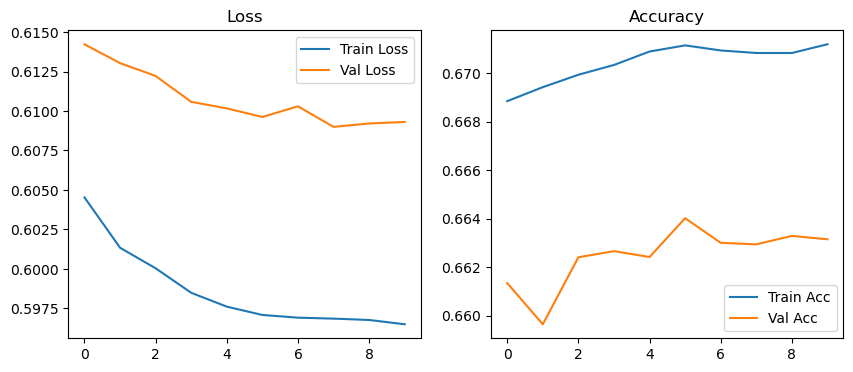

In [ ]:
# ========== Config ==========
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SimpleLSTM(
    input_size=23, 
    hidden_size=64, 
    num_layers=1
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ========== DataLoader ==========
train_loader = DataLoader(train_set, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=collate_fn)

# ========== Trainning ==========
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    # ======= Train Mode =======
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for padded_seqs, lengths, y in train_loader:
        padded_seqs, lengths, y = padded_seqs.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(padded_seqs, lengths)
        loss = criterion(logits, y)
        loss.backward()


        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == y).sum().item()
        total_samples += y.size(0)

    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # ======= Evaluation Mode =======
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for padded_seqs, lengths, y in test_loader:
            padded_seqs, lengths, y = padded_seqs.to(device), lengths.to(device), y.to(device)
            logits = model(padded_seqs, lengths)
            loss = criterion(logits, y)
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_val += (predicted == y).sum().item()
            total_val += y.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    test_losses.append(avg_val_loss)
    test_accuracies.append(val_accuracy)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
          f"LR: {current_lr:.6f}")

print("✅ 训练完成！")

# ========== Plotting ==========
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()
